In [1]:
import lightgbm as lgb
import os
import math
import pandas as pd
import numpy as np
import random
import gc
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder

np.random.seed(2019)
random.seed(2019)
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 280)
pd.set_option('display.max_colwidth', 150)
data_path = '/data/workspace/kimi/tencent_ads/2020/dataset'
preprocess_path = 'preprocess'

In [2]:
user_base_statics_df= pd.read_pickle(f'{preprocess_path}/train_user_base_statics.pkl')
user_base_statics_df.columns = ['_'.join(i) for i in user_base_statics_df.columns.values]
label_df = pd.read_csv(f'{data_path}/train_preliminary/user.csv')
user_base_statics_df = user_base_statics_df.merge(label_df,on='user_id')
user_base_statics_df['click_times_sum_log'] = user_base_statics_df['click_times_sum'].apply(lambda x :math.log(x))
user_base_statics_df['click_times_count_log'] = user_base_statics_df['click_times_count'].apply(lambda x :math.log(x))
user_base_statics_df['gender'] = user_base_statics_df['gender'] -1
user_base_statics_df = user_base_statics_df.astype(float)
print(user_base_statics_df)


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique   age  gender  click_times_sum_log  click_times_count_log
0            1.0             14.0               13.0           12.0                 6.0                       3.0                   12.0               9.0   4.0     0.0             2.639057               2.564949
1            2.0             46.0               45.0           42.0                20.0                       3.0                   36.0              15.0  10.0     0.0             3.828641               3.806662
2            3.0             30.0               30.0           30.0                17.0                       6.0                   28.0               8.0   7.0     1.0             3.401197               3.401197
...          ...              ...                ...            ...                 ...                       ...                    ...            

In [3]:
train_df = user_base_statics_df[user_base_statics_df.user_id <= 720000]
valid_df = user_base_statics_df[user_base_statics_df.user_id > 720000]
valid_df = valid_df[valid_df.user_id < 2000000]
print(valid_df)


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  3.0     1.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  2.0     1.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  2.0     0.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

In [4]:
def merge_features(train_df,valid_df,train_file,valid_file,target_encode=False):
    train_features_df  = pd.read_pickle(f'{preprocess_path}/{train_file}')
    valid_features_df = pd.read_pickle(f'{preprocess_path}/{valid_file}')
    if target_encode:
        train_features_df.columns = [ '_'.join(i) for i in train_features_df.columns.values  ]
        valid_features_df.columns = ['_'.join(i) for i in valid_features_df.columns.values  ]

    train_df = train_df.merge(train_features_df,on='user_id')
    valid_df = valid_df.merge(valid_features_df,on='user_id')
    print(train_df)
    print(valid_df)
    return train_df,valid_df


In [5]:
train_df,valid_df = merge_features(train_df,valid_df,'train_user_target_encoder_gender.pkl','valid_user_target_encoder_gender.pkl',True)

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique   age  gender  click_times_sum_log  click_times_count_log  creative_id_gender0_kfold_mean_min  \
0            1.0             14.0               13.0           12.0                 6.0                       3.0                   12.0               9.0   4.0     0.0             2.639057               2.564949                            0.628134   
1            2.0             46.0               45.0           42.0                20.0                       3.0                   36.0              15.0  10.0     0.0             3.828641               3.806662                            0.000000   
2            3.0             30.0               30.0           30.0                17.0                       6.0                   28.0               8.0   7.0     1.0             3.401197               3.401197                            0.00

In [6]:
# train_x = train_df.drop(['age','user_id','gender','advertiser_id_seq','industry_seq','product_id_seq'], axis=1)
# train_y = train_df['age'].astype(int)

# valid_x = valid_df.drop(['age','user_id','gender','advertiser_id_seq','industry_seq','product_id_seq'], axis=1)
# valid_y = valid_df['age'].astype(int)

drop_list = ['age','user_id','gender','click_times_sum','click_times_count']
train_x = train_df.drop(drop_list, axis=1)
train_y = train_df['gender'].astype(int)

valid_x = valid_df.drop(drop_list, axis=1)
valid_y = valid_df['gender'].astype(int)
#print(x)
#print(y)
print(train_x)
print(train_y)

print(valid_x)
print(valid_y)

#train_x,valid_x,train_y,valid_y =  train_test_split(x,y,test_size=0.20, random_state=42)
#print(train_x.shape)
train_data = lgb.Dataset(train_x.values, label=train_y, feature_name=list(train_x.columns),free_raw_data=False)
valid_data = lgb.Dataset(valid_x.values, label=valid_y, feature_name=list(train_x.columns),free_raw_data=False,reference=train_data)



        ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  click_times_sum_log  click_times_count_log  creative_id_gender0_kfold_mean_min  creative_id_gender0_kfold_mean_max  creative_id_gender0_kfold_mean_mean  \
0                12.0                 6.0                       3.0                   12.0               9.0             2.639057               2.564949                            0.628134                            1.000000                             0.782592   
1                42.0                20.0                       3.0                   36.0              15.0             3.828641               3.806662                            0.000000                            1.000000                             0.698414   
2                30.0                17.0                       6.0                   28.0               8.0             3.401197               3.401197                            0.000000                 

# params = {
    'boosting_type': 'gbdt',
    'objective': 'softmax',
    'num_class':2,
    'metric': 'multi_error',
    'num_leaves': 128 + 1,
    'learning_rate': 0.1,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}
print('Starting training...')
# train

gbm = lgb.train(params,
                train_data,
                 valid_sets=[train_data,valid_data],
                num_boost_round = 2000,
                early_stopping_rounds=100
               )
gbm.save_model('model/gender_target_encode.model')
print('Feature importances:', list(gbm.feature_importance()))

In [8]:
before_one_hot =  train_y.values.reshape([-1,1])
print(before_one_hot)
enc = OneHotEncoder()
enc.fit(before_one_hot)

one_hoted_y  = enc.transform(before_one_hot).toarray()
print(one_hoted_y.shape)


[[0]
 [0]
 [1]
 ...
 [1]
 [0]
 [0]]
(720000, 2)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [9]:
gc.collect()
y_pred = gbm.predict(train_x.astype(float))
for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
                
#print(precision_score(one_hoted_y, y_pred,average='micro'))

ret = []
for user_id,age in zip(range(1000000),y_pred):
    ret.append([int(user_id),int(age.tolist().index(1) + 1)])
ret_df = pd.DataFrame(ret,columns=['user_id','predicted_age'])
print(ret_df['predicted_age'].value_counts())

1    484566
2    235434
Name: predicted_age, dtype: int64


In [10]:

before_one_hot =  valid_y.values.reshape([-1,1])
print(before_one_hot)
enc = OneHotEncoder()
enc.fit(before_one_hot)

one_hoted_y  = enc.transform(before_one_hot).toarray()
print(one_hoted_y.shape)


[[1]
 [1]
 [0]
 ...
 [1]
 [0]
 [1]]
(180000, 2)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
y_pred = gbm.predict(valid_x.astype(float))
for i in range(len(y_pred)):
        max_value=max(y_pred[i])
        for j in range(len(y_pred[i])):
            if max_value==y_pred[i][j]:
                y_pred[i][j]=1
            else:
                y_pred[i][j]=0
                
precision_score(one_hoted_y, y_pred,average='micro')


0.9311

In [12]:
ret = []
for user_id,age,label_age in zip(range(1000000),y_pred,valid_y):
    ret.append([int(user_id + 720001),int(age.tolist().index(1)),label_age])
ret_df = pd.DataFrame(ret,columns=['user_id','predicted_age','label_age'])
print(ret_df)
print(ret_df['predicted_age'].value_counts())

        user_id  predicted_age  label_age
0        720001              0          1
1        720002              1          1
2        720003              0          0
...         ...            ...        ...
179997   899998              1          1
179998   899999              0          0
179999   900000              1          1

[180000 rows x 3 columns]
0    121673
1     58327
Name: predicted_age, dtype: int64


In [13]:
true_user_df = ret_df[ret_df.predicted_age == ret_df.label_age ]
print(true_user_df)


        user_id  predicted_age  label_age
1        720002              1          1
2        720003              0          0
3        720004              0          0
...         ...            ...        ...
179997   899998              1          1
179998   899999              0          0
179999   900000              1          1

[167598 rows x 3 columns]


In [14]:
true_user_df = true_user_df.merge(user_base_statics_df,on='user_id')
print(true_user_df)

        user_id  predicted_age  label_age  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
0        720002              1          1             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  2.0     1.0             3.367296               3.367296
1        720003              0          0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  2.0     0.0             3.044522               2.995732
2        720004              0          0             12.0               11.0           11.0                 9.0                       4.0                   11.0               6.0  3.0     0.0             2.484907               2.397895
...         ...            ...        ...           

4.0           2
5.0           5
6.0          25
7.0         101
8.0         429
9.0        1905
10.0       6743
11.0       8038
12.0       7459
13.0       7078
14.0       6719
15.0       6254
16.0       5783
17.0       5541
18.0       5148
19.0       4903
20.0       4715
21.0       4330
22.0       4126
23.0       3858
24.0       3697
25.0       3456
26.0       3232
27.0       3131
28.0       3100
29.0       2947
30.0       2721
31.0       2529
32.0       2442
33.0       2380
34.0       2299
35.0       2152
36.0       2005
37.0       1900
38.0       1863
39.0       1743
40.0       1670
41.0       1586
42.0       1521
43.0       1503
44.0       1366
45.0       1301
46.0       1235
47.0       1255
48.0       1120
49.0       1105
50.0       1008
51.0        909
52.0        922
53.0        936
           ... 
370.0         1
372.0         1
375.0         2
376.0         1
384.0         2
388.0         1
389.0         2
392.0         1
395.0         1
396.0         1
403.0         1
406.0   

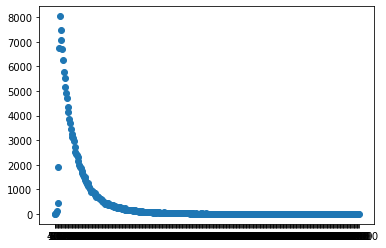

In [15]:
plt_values =  true_user_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

10.0       5794
11.0       7957
12.0       7321
13.0       6957
14.0       6666
15.0       6123
16.0       5798
17.0       5452
18.0       5095
19.0       4952
20.0       4584
21.0       4265
22.0       4253
23.0       3908
24.0       3644
25.0       3513
26.0       3267
27.0       3136
28.0       3033
29.0       2977
30.0       2783
31.0       2519
32.0       2464
33.0       2415
34.0       2319
35.0       2201
36.0       2132
37.0       1982
38.0       1880
39.0       1772
40.0       1723
41.0       1631
42.0       1523
43.0       1534
44.0       1461
45.0       1379
46.0       1273
47.0       1241
48.0       1234
49.0       1184
50.0       1086
51.0       1054
52.0       1028
53.0        870
54.0        885
55.0        936
56.0        810
57.0        792
58.0        762
59.0        790
           ... 
427.0         1
428.0         1
430.0         2
438.0         1
441.0         2
449.0         1
450.0         1
452.0         1
453.0         1
461.0         2
462.0         1
467.0   

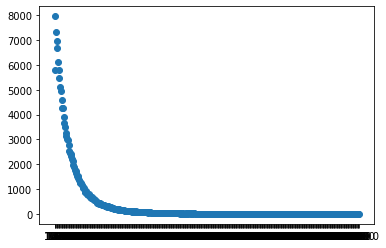

In [16]:
plt_values =  true_user_df['click_times_sum'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

3.0     37831
4.0     28132
2.0     27668
        ...  
8.0      5948
9.0      3605
10.0     2140
Name: age, Length: 10, dtype: int64


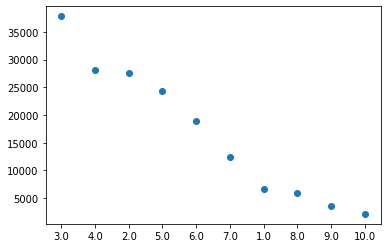

In [17]:
plt_values =  true_user_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

In [18]:
valid_user_base_statics_df =  user_base_statics_df[user_base_statics_df.user_id > 720000]
print(valid_user_base_statics_df)

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  3.0     1.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  2.0     1.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  2.0     0.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  3.0     1.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  2.0     1.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  2.0     0.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

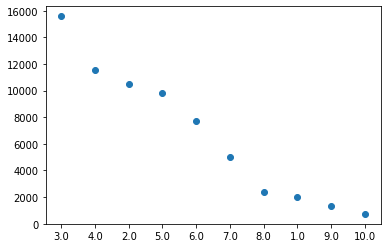

In [19]:
len_10_30_df = valid_user_base_statics_df[valid_user_base_statics_df.click_times_count > 10]
len_10_30_df = len_10_30_df[len_10_30_df.click_times_count <=20]
print(valid_user_base_statics_df)
plt_values =  len_10_30_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

3.0     40771
4.0     30059
2.0     29834
        ...  
8.0      6392
9.0      3856
10.0     2310
Name: age, Length: 10, dtype: int64


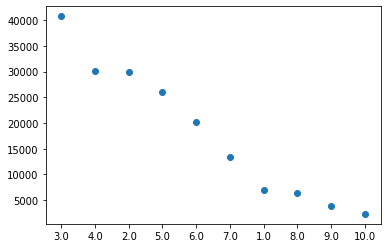

In [20]:

plt_values =  valid_user_base_statics_df['age'].value_counts()
print(plt_values)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

4.0           3
5.0           5
6.0          28
7.0         117
8.0         471
9.0        2080
10.0       7395
11.0       8741
12.0       8128
13.0       7680
14.0       7294
15.0       6769
16.0       6258
17.0       5960
18.0       5539
19.0       5265
20.0       5060
21.0       4629
22.0       4408
23.0       4125
24.0       3957
25.0       3686
26.0       3464
27.0       3336
28.0       3295
29.0       3148
30.0       2891
31.0       2686
32.0       2600
33.0       2532
34.0       2431
35.0       2297
36.0       2127
37.0       2019
38.0       1982
39.0       1857
40.0       1760
41.0       1688
42.0       1626
43.0       1604
44.0       1452
45.0       1395
46.0       1316
47.0       1323
48.0       1196
49.0       1188
50.0       1067
51.0        979
52.0       1005
53.0       1001
           ... 
376.0         1
384.0         2
388.0         1
389.0         2
390.0         1
392.0         1
393.0         1
395.0         1
396.0         1
403.0         1
406.0         1
408.0   

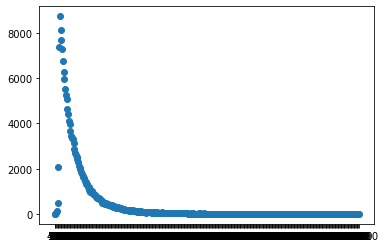

In [21]:
plt_values =  valid_user_base_statics_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

10.0       6361
11.0       8682
12.0       7974
13.0       7563
14.0       7204
15.0       6648
16.0       6265
17.0       5880
18.0       5490
19.0       5312
20.0       4943
21.0       4578
22.0       4551
23.0       4151
24.0       3912
25.0       3752
26.0       3484
27.0       3343
28.0       3231
29.0       3197
30.0       2957
31.0       2683
32.0       2620
33.0       2585
34.0       2470
35.0       2320
36.0       2265
37.0       2103
38.0       1985
39.0       1899
40.0       1840
41.0       1735
42.0       1609
43.0       1636
44.0       1562
45.0       1472
46.0       1354
47.0       1322
48.0       1295
49.0       1269
50.0       1152
51.0       1139
52.0       1094
53.0        935
54.0        962
55.0        997
56.0        864
57.0        832
58.0        819
59.0        845
           ... 
430.0         2
432.0         1
438.0         1
441.0         2
449.0         1
450.0         1
452.0         1
453.0         1
461.0         2
462.0         2
467.0         1
474.0   

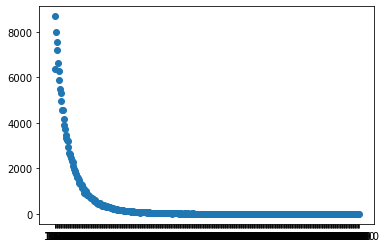

In [22]:
plt_values =  valid_user_base_statics_df['click_times_sum'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  3.0     1.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  2.0     1.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  2.0     0.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

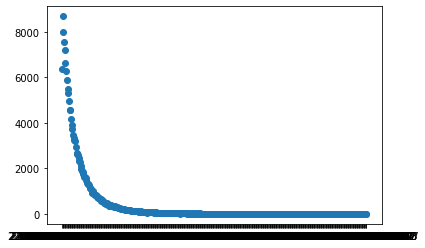

In [23]:
valid_user_base_statics_df['click_times_sum_log'] =  valid_user_base_statics_df['click_times_sum'].apply(lambda x: math.log(x))
print(valid_user_base_statics_df)
plt_values =  valid_user_base_statics_df['click_times_sum_log'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()

In [24]:
print(valid_user_base_statics_df)

         user_id  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
720000  720001.0             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  3.0     1.0             3.465736               3.332205
720001  720002.0             29.0               29.0           26.0                 2.0                       5.0                   18.0              19.0  2.0     1.0             3.367296               3.367296
720002  720003.0             21.0               20.0           17.0                 8.0                       3.0                   11.0              10.0  2.0     0.0             3.044522               2.995732
...          ...              ...                ...            ...                 ...                       ...                    ...               .

In [25]:
false_user_df = ret_df[ret_df.predicted_age != ret_df.label_age ]
false_user_df = false_user_df.merge(user_base_statics_df,on='user_id')
print(false_user_df)

       user_id  predicted_age  label_age  click_times_sum  click_times_count  ad_id_nunique  product_id_nunique  product_category_nunique  advertiser_id_nunique  industry_nunique  age  gender  click_times_sum_log  click_times_count_log
0       720001              0          1             32.0               28.0           26.0                11.0                       2.0                   20.0              11.0  3.0     1.0             3.465736               3.332205
1       720015              0          1             85.0               74.0           60.0                13.0                       5.0                   30.0              15.0  3.0     1.0             4.442651               4.304065
2       720017              1          0             14.0               13.0           13.0                 6.0                       2.0                   11.0               6.0  2.0     0.0             2.639057               2.564949
...        ...            ...        ...              ..

4.0        1
6.0        3
7.0       16
8.0       42
9.0      175
10.0     652
11.0     703
12.0     669
13.0     602
14.0     575
15.0     515
16.0     475
17.0     419
18.0     391
19.0     362
20.0     345
21.0     299
22.0     282
23.0     267
24.0     260
25.0     230
26.0     232
27.0     205
28.0     195
29.0     201
30.0     170
31.0     157
32.0     158
33.0     152
34.0     132
35.0     145
36.0     122
37.0     119
38.0     119
39.0     114
40.0      90
41.0     102
42.0     105
43.0     101
44.0      86
45.0      94
46.0      81
47.0      68
48.0      76
49.0      83
50.0      59
51.0      70
52.0      83
53.0      65
54.0      65
        ... 
205.0      1
207.0      2
211.0      2
212.0      1
214.0      2
215.0      2
218.0      3
220.0      2
224.0      1
225.0      1
227.0      1
228.0      1
230.0      1
235.0      1
236.0      1
237.0      1
239.0      1
240.0      3
242.0      1
243.0      1
245.0      1
246.0      2
247.0      1
252.0      1
253.0      1
254.0      1

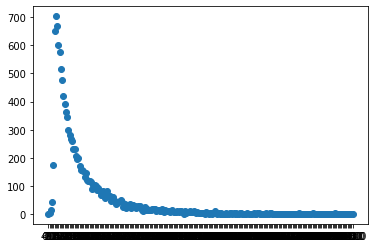

In [26]:
plt_values =  false_user_df['click_times_count'].value_counts().sort_index()
pd.set_option('display.max_rows', 100)
print(plt_values)
pd.set_option('display.max_rows', 6)
x = [str(i) for i in plt_values.index]
y = plt_values.values
plt.scatter(x,y)
plt.show()